<a href="https://colab.research.google.com/github/helomelo1/GPT_with_Karpathy/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1017]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1018]:
def f(x):
  return 3*x**2 - 4*x + 5

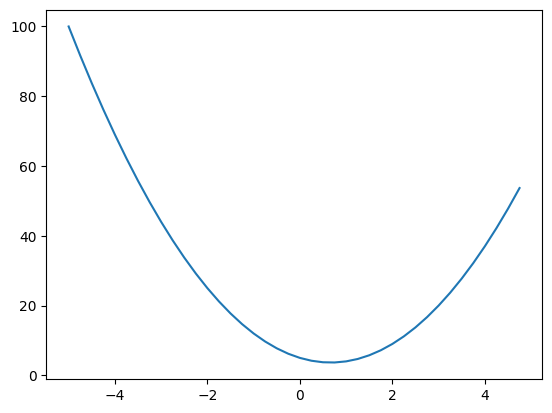

In [1019]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [1020]:
a = 2.0
b = -1.4
c = 15.0
d = a * b + c
print(d)

12.2


In [1021]:
h = 0.000000001

a = 2.0
b = -1.4
c = 15.0

d1 = a * b + c
c += h
d2 = a * b + c

print(d1)
print(d2)
print("slope:",(d2 - d1) / h)

12.2
12.200000001
slope: 1.000000082740371


In [1022]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [1023]:
a = Value(2.0)
b = Value(-1.4)
c = Value(11)
d = a * b
e = d + c
f = Value(1.6)
g = e * f

In [1024]:
a.label = 'a'
b.label = 'b'
c.label = 'c'
d.label = 'd'
e.label = 'e'
f.label = 'f'
g.label = 'g'

In [1025]:
d._op

'*'

In [1026]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [1027]:
a.grad = -2.24
b.grad = 3.2
c.grad = 1.6
d.grad = 1.6
e.grad = 1.6
f.grad = 8.2
g.grad = 1.0

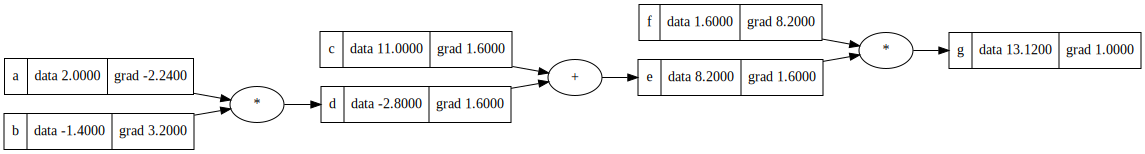

In [1028]:
draw_dot(g)

In [1029]:
def func():
    h = 0.00001

    a = Value(2.0)
    b = Value(-1.4)
    c = Value(11)
    d = a * b
    e = d + c
    f = Value(1.6)
    g1 = e * f

    a = Value(2.0)
    b = Value(-1.4)
    c = Value(11)
    d = a * b
    e = d + c
    f = Value(1.6 + h)
    g2 = e * f

    print((g2.data - g1.data) / h)

func()

8.200000000080365


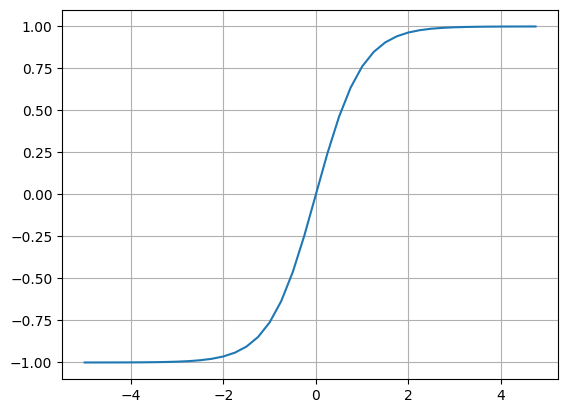

In [1030]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid();

In [1031]:
x1 = Value(1.6, label = 'x1')
x2 = Value(2.3, label = 'x2')

w1 = Value(2.0, label = 'w1')
w2 = Value(-1.4, label = 'w2')

b = Value(0.1, label = 'b')

x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1.label = 'x1w1'
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1+x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

In [1032]:
o.backward()

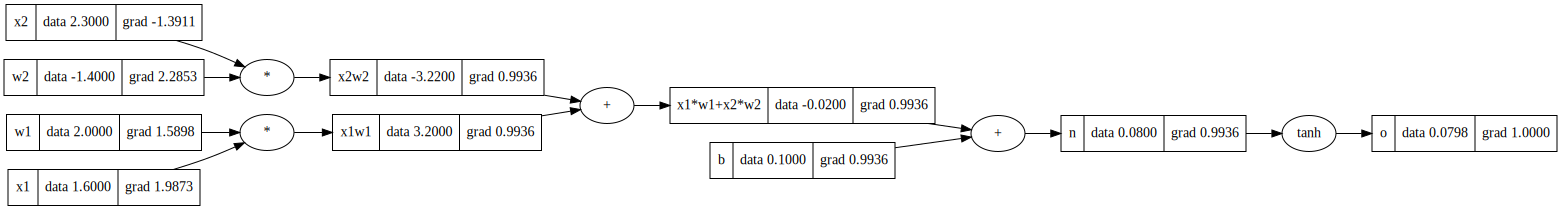

In [1033]:
draw_dot(o)

In [1034]:
a = Value(2)
b = Value(0.1)
a / b

Value(data=20.0)

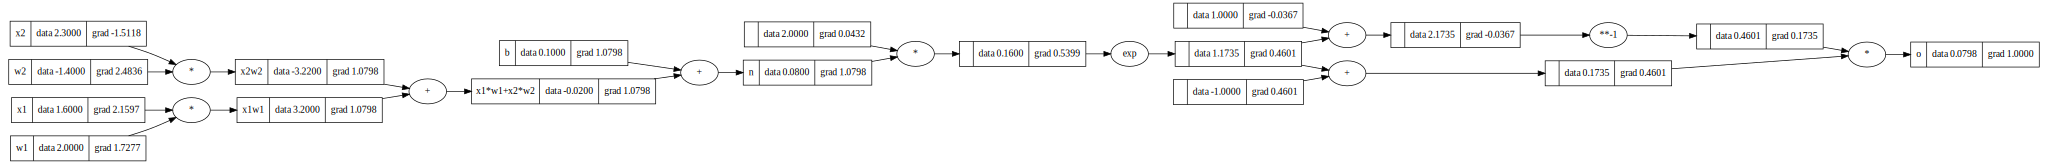

In [1035]:
x1 = Value(1.6, label = 'x1')
x2 = Value(2.3, label = 'x2')

w1 = Value(2.0, label = 'w1')
w2 = Value(-1.4, label = 'w2')

b = Value(0.1, label = 'b')

x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1.label = 'x1w1'
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1+x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [1036]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, 1.6, 0.4]
n = MLP(4, [4, 3, 1])
n(x).backward()

In [1037]:
len(n.parameters())

39

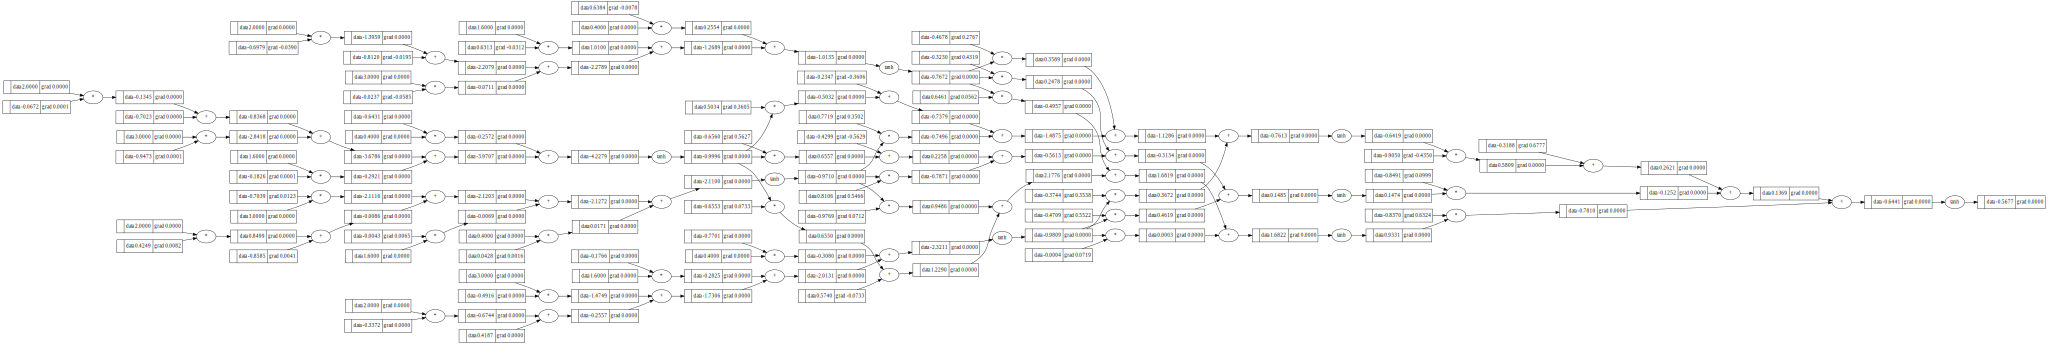

In [1038]:
draw_dot(n(x))

In [1039]:
xs = [
    [1.5, 4, 0.1, 6.0],
    [2.0, 2.5, 3.1, 5.5],
    [0.1, 0.9, 3.2, 1.4],
    [1.6, 2.9, 1.1, 3.7]
]

ys = [1.0, -1.0, -1.0, 1.0]


In [1040]:
for k in range(1000):
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))
    # print(loss)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -0.1 * p.grad

ypred = [n(x) for x in xs]
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))

In [1041]:
loss

Value(data=0.0016628271965823615)

In [1042]:
ypred

[Value(data=0.9817883345028783),
 Value(data=-0.9759947430280129),
 Value(data=-0.9821282706216711),
 Value(data=0.9791310909930598)]